<a href="https://colab.research.google.com/github/rakibulhaque9954/Machine_Learning_Translation/blob/main/machine_translation_with_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense,Flatten,SimpleRNN,InputLayer,Conv1D,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input, Embedding,TextVectorization)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from tensorboard.plugins import projector

# Dataset Prepration and Preprocessing

## Dataset Download

### Small dataset manythings.org

In [2]:
!wget https://www.manythings.org/anki/fra-eng.zip

--2023-10-21 11:49:30--  https://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7757635 (7.4M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   7.40M  3.88MB/s    in 1.9s    

2023-10-21 11:49:33 (3.88 MB/s) - ‘fra-eng.zip’ saved [7757635/7757635]



In [3]:
!unzip '/content/fra-eng.zip' -d '/content/dataset/'


Archive:  /content/fra-eng.zip
  inflating: /content/dataset/_about.txt  
  inflating: /content/dataset/fra.txt  


### Kaggle Dataset

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d dhruvildave/en-fr-translation-dataset
!unzip "/content/en-fr-translation-dataset.zip" -d "/content/dataset/"

In [ ]:
dataset = tf.data.experimental.CsvDataset(
  "/content/dataset/en-fr.csv",
  [
    tf.string,
    tf.string
  ],
)

## Data Processing

In [64]:
text_dataset = tf.data.TextLineDataset('/content/dataset/fra.txt')



In [65]:
for i in text_dataset.take(5):
  print(i)



tf.Tensor(b'Go.\tVa !\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)', shape=(), dtype=string)
tf.Tensor(b'Go.\tMarche.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8090732 (Micsmithel)', shape=(), dtype=string)
tf.Tensor(b'Go.\tEn route !\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8267435 (felix63)', shape=(), dtype=string)
tf.Tensor(b'Go.\tBouge !\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #9022935 (Micsmithel)', shape=(), dtype=string)
tf.Tensor(b'Hi.\tSalut !\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #509819 (Aiji)', shape=(), dtype=string)


In [89]:
VOCAB_SIZE = 20000
ENGLISH_SEQUENCE_LENGTH = 64 # explicitly initialising input and output length of sequences
FRENCH_SEQUENCE_LENGTH = 64
EMBEDDING_DIM = 300
BATCH_SIZE = 64





### Vectorizing layers

In [67]:
english_vectorize_layer = tf.keras.layers.TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=ENGLISH_SEQUENCE_LENGTH)




In [68]:
french_vectorize_layer = tf.keras.layers.TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=FRENCH_SEQUENCE_LENGTH)

### Splitting and organising tokens

In [69]:
def selector(input_text):
  """[starttoken] and [endtoken] token initialized just as the model explanation the [endtoken] part is the output"""
  split_text = tf.strings.split(input_text, sep='\t')
  return {'input_1' : split_text[0 : 1], 'input_2' : '[starttoken] '+ split_text[1 : 2]}, split_text[1 : 2] + ' [endtoken]'





In [70]:
split_dataset = text_dataset.map(selector)




In [71]:
for i in split_dataset.take(1):
  print(i)

({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'[starttoken] Va !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Va ! [endtoken]'], dtype=object)>)


**As the data shows how the inputs have been seperated:**
- Input 1 - {'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.']>
- Input 2 - 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'[starttoken] Va !']>
- Output - <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Va ! [endtoken]']>

***The inputs and output has been processed for training, the split dataset is for training while init is for vocabulary creation.***

### Initialising Data for creating Vocabulary

In [72]:
def selector(input_text):
  """This function is needed to create vocabulary"""
  split_text = tf.strings.split(input_text, sep='\t')
  return split_text[0 : 1], '[starttoken] ' + split_text[1 : 2] + ' [endtoken]' # combining input 2 and output the decoder part

In [73]:
init_dataset = text_dataset.map(selector)


In [74]:
for i in init_dataset.take(5):
  print(i)


(<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'[starttoken] Va ! [endtoken]'], dtype=object)>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'[starttoken] Marche. [endtoken]'], dtype=object)>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'[starttoken] En route ! [endtoken]'], dtype=object)>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'[starttoken] Bouge ! [endtoken]'], dtype=object)>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Hi.'], dtype=object)>, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'[starttoken] Salut ! [endtoken]'], dtype=object)>)


### English and French Vocabulary creation

In [75]:
english_training_data = init_dataset.map(lambda x,y: x) # x is for eng
english_vectorize_layer.adapt(english_training_data)




In [76]:
french_training_data = init_dataset.map(lambda x,y: y) # y is for french
french_vectorize_layer.adapt(french_training_data)

### Vectorizing tokens for training

In [77]:
def vectorizer(inputs, output):
  return {'input_1' : english_vectorize_layer(inputs['input_1']),
          'input_2' : french_vectorize_layer(inputs['input_2']) }, french_vectorize_layer(output)

# making the input_1 and input_2 together for inputs




In [86]:
print(french_vectorize_layer.get_vocabulary()[:10])
print(english_vectorize_layer.get_vocabulary()[:10])




['', '[UNK]', 'starttoken', 'endtoken', 'je', 'de', 'pas', 'que', 'ne', 'le']
['', '[UNK]', 'i', 'you', 'to', 'the', 'a', 'tom', 'is', 'that']


**- Now starttoken and endtoken are added as tokens in the vocabulary.**

In [98]:
dataset = split_dataset.map(vectorizer)

In [99]:
for i in dataset.take(1):
  print(i)

({'input_1': <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[44,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])>, 'input_2': <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[  2, 103,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])>}, <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[103,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,

In [100]:
print(f'ENG: {english_vectorize_layer.get_vocabulary()[44]}')
print(f'FR: {french_vectorize_layer.get_vocabulary()[2]}')
print(f'FR: {french_vectorize_layer.get_vocabulary()[103]}')
print(f'FR: {french_vectorize_layer.get_vocabulary()[3]}')


ENG: go
FR: starttoken
FR: va
FR: endtoken


### Training data Batching and Prefetching

In [101]:
dataset = dataset.shuffle(2048).unbatch()
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.AUTOTUNE)


In [102]:
dataset

<_PrefetchDataset element_spec=({'input_1': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 64), dtype=tf.int64, name=None))>

In [103]:
NUM_BATCHES = int(200000 / BATCH_SIZE)


In [104]:
train_dataset = dataset.take(int(0.9 * NUM_BATCHES))
val_dataset = dataset.skip(int(0.9 * NUM_BATCHES))

In [105]:
train_dataset

<_TakeDataset element_spec=({'input_1': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 64), dtype=tf.int64, name=None))>

# Modeling

## Seq2Seq Model
<h4>Model Diagram<h4>
<img src='https://miro.medium.com/max/942/1*KtWwvLK-jpGPSnj3tStg-Q.png'>

In [106]:
NUM_UNITS = 256

### Encoder

In [108]:
input = Input(shape=(ENGLISH_SEQUENCE_LENGTH,), dtype='int64', name='input_1')
x = Embedding(VOCAB_SIZE, NUM_UNITS)(input)
encoded_input = Bidirectional(GRU(NUM_UNITS),)(x)


### Decoder

In [109]:
shifted_target = Input(shape=(FRENCH_SEQUENCE_LENGTH,), dtype='int64', name='input_2')
x = Embedding(VOCAB_SIZE, EMBEDDING_DIM)(shifted_target)

x = GRU(NUM_UNITS * 2, return_sequences=True)(x, initial_state=encoded_input)
# NUM_UNITS is times 2 because bidirectional which gives 512 dimensions and return sequences is true becuase we need the output
# we are using a unidirectional GRU because when doing translation the movement is from left to right
# initial state is the hidden states from the encoder which becomes the input of the decoder

### Output Layer

In [110]:
x = Dropout(0.5)(x)
x = Dense(VOCAB_SIZE, activation='softmax')(x) # we are using softmax to classify the correct word from the vocab size,
# dense does this by converting the output of (Batch, Sequence_length, output_dims) output_dims to vocab_size
seq2seq_model = Model(inputs=[input, shifted_target], outputs=x)
seq2seq_model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 64, 256)              5120000   ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 64, 300)              6000000   ['input_2[0][0]']             
                                                                                              

In [170]:
class BLEU(tf.keras.metrics.Metric):
  def __init__(self, name='bleu_score'):
    super(BLEU, self).__init__()
    self.bleu_result = 0

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.argmax(y_pred, axis=-1) # seeing if the predicted word is true or not
    self.bleu_result = 0

    for i, j in zip(y_true, y_pred):
      tf.autograph.experimental.set_loop_options()

      total_words = tf.math.count_nonzero(i)
      total_matches = 0

      for word in i:
        if word == 0:
          break
        for q in range(len(j)):
          if j[q] == 0:
            break
          if j[q] == word:
            total_matches += 1
            j = tf.boolean_mask(j, [False if y == q else True for y in range(len(j))])
            break
            # removes the matched word in the predicted sequence

      self.bleu_result += total_matches / total_words

  def result(self):
    return self.bleu_result/BATCH_SIZE



In [171]:
j = tf.constant([1, 2, 3, 4, 5])
j = tf.boolean_mask(j, [False if y == 2 else True for y in range(len(j))])
print(j)


tf.Tensor([1 2 4 5], shape=(4,), dtype=int32)


In [172]:
seq2seq_model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(1e-4),
                      metrics=[BLEU()], run_eagerly=True)


In [ ]:
history = seq2seq_model.fit(train_dataset, epochs=15, validation_data=val_dataset)


In [174]:
# seq2seq_model.save('/content/drive/MyDrive/seq2seq_model.hdf5')



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Model loss and accuracy Plots

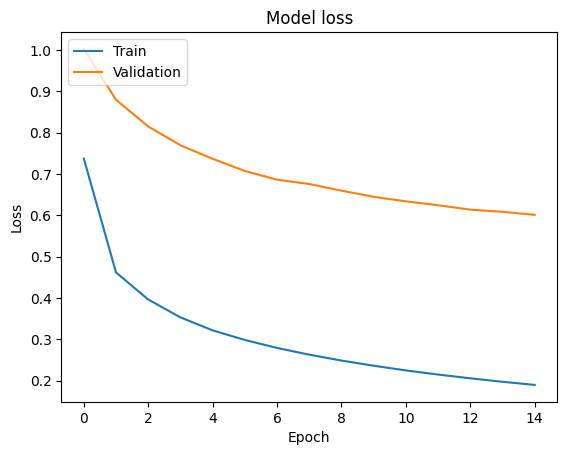

In [117]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

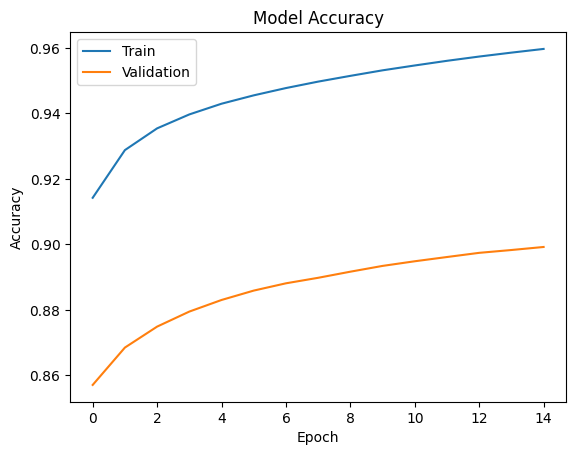

In [118]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Load saved model from drive

In [176]:
from keras.models import load_model

model = load_model('/content/drive/MyDrive/seq2seq_model.h5')


In [178]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=[BLEU()], run_eagerly=True)

In [182]:
model.evaluate(val_dataset.take(20))


20/20 [==============================] - 136s 5s/step - loss: 0.3300 - bleu_6: 0.5150


[0.3299589455127716, 0.5149903048340548]

# Testing


In [120]:
index_to_word = {x: y for x, y in zip(range(len(french_vectorize_layer.get_vocabulary())),
                                      french_vectorize_layer.get_vocabulary())}



In [121]:
index_to_word

{0: '',
 1: '[UNK]',
 2: 'starttoken',
 3: 'endtoken',
 4: 'je',
 5: 'de',
 6: 'pas',
 7: 'que',
 8: 'ne',
 9: 'le',
 10: 'à',
 11: 'la',
 12: 'vous',
 13: 'tom',
 14: 'il',
 15: 'est',
 16: 'tu',
 17: 'un',
 18: 'ce',
 19: 'a',
 20: 'nous',
 21: 'les',
 22: 'une',
 23: 'en',
 24: 'jai',
 25: 'suis',
 26: 'pour',
 27: 'me',
 28: 'faire',
 29: 'cest',
 30: 'dans',
 31: 'plus',
 32: 'des',
 33: 'elle',
 34: 'ça',
 35: 'tout',
 36: 'qui',
 37: 'te',
 38: 'fait',
 39: 'ma',
 40: 'du',
 41: 'mon',
 42: 'avec',
 43: 'veux',
 44: 'se',
 45: 'au',
 46: 'si',
 47: 'et',
 48: 'cette',
 49: 'sont',
 50: 'y',
 51: 'quil',
 52: 'très',
 53: 'pense',
 54: 'cela',
 55: 'nest',
 56: 'son',
 57: 'sur',
 58: 'votre',
 59: 'pourquoi',
 60: 'dit',
 61: 'temps',
 62: 'sais',
 63: 'être',
 64: 'été',
 65: 'était',
 66: 'peux',
 67: 'moi',
 68: 'nai',
 69: 'chose',
 70: 'ici',
 71: 'jamais',
 72: 'ils',
 73: 'lui',
 74: 'comment',
 75: 'où',
 76: 'bien',
 77: 'estce',
 78: 'ton',
 79: 'quelque',
 80: 'vraime

In [126]:
def translator(english_sentence):
  tokenized_english_sentence = english_vectorize_layer([english_sentence])
  shifted_target = 'starttoken'
  ### Personalized Input ###


  for i in range(FRENCH_SEQUENCE_LENGTH):
    tokenized_shifted_target = french_vectorize_layer([shifted_target])
    predictions = seq2seq_model.predict([tokenized_english_sentence, tokenized_shifted_target])
    french_word_index = tf.argmax(predictions, axis=-1)[0][i].numpy()
    print(french_word_index)
    current_word = index_to_word[french_word_index]
    if current_word == 'endtoken':
      break
    shifted_target += ' ' + current_word
    ### Convert all tokens and add relationship to each token to form a sentence
  return shifted_target[11: ]







In [181]:
translator('Lets eat dinner')



1/1 [==============================] - 0s 46ms/step
2393
1/1 [==============================] - 0s 42ms/step
10
1/1 [==============================] - 0s 49ms/step
11
1/1 [==============================] - 0s 49ms/step
107
1/1 [==============================] - 0s 50ms/step
3


'jouons à la maison'

Not quite accurate

In [136]:
word_to_index = {y: x for x, y in zip(range(len(french_vectorize_layer.get_vocabulary())),
                                      french_vectorize_layer.get_vocabulary())}

In [137]:
word_to_index['passetil']

2549

In [139]:
index_to_word[2549]

'passetil'

Accuracy metric isnt suited much for this translation, instead BLEU shall be used.
- B - Bi
- L - Lingual
- E - Evaluation
- U - Understudy

BLEU metric shall be used for translation based evaluation.

**Verdict**
- Even though accuracy was high about 90%. when evaluated the metric BLEU score was around 50 - 60% which is quite low for a translation model.

For machine translation tasks, BLEU scores can range from 0 to 100. Higher scores are better.
- The Model needs more training and a bigger dataset for training.
